<a href="https://colab.research.google.com/github/aleks-haksly/portfolio/blob/main/Marketing%20analytics/Metrics/Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Расчитаем основные продуктовые метрики, связанные с активностью пользователей:

* [retention](#retention)
* [rolling retention](#rolling)
* [lifetime](#lifetime)
* [churn rate](#churn)
* [mau](#mau), [wau](#wau), [dau](#dau)

In [1]:
!wget https://raw.githubusercontent.com/aleks-haksly/portfolio/refs/heads/main/Marketing%20analytics/Metrics/registrations.csv -q
!wget https://raw.githubusercontent.com/aleks-haksly/portfolio/refs/heads/main/Marketing%20analytics/Metrics/entries.csv -q

Таблицами для для работы являются `registrations.csv` и `entries.csv`. В них хранятся данные о регистрациях пользователей и входа на платформу соответственно.

<a name='retention'></a>
### 1 Посчитаем Retention 15 дня (в процентах) для пользователей, зарегистрированных в январе



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Для удобства объедини данные о пользователях в один DataFrame
df_registrations = pd.read_csv('registrations.csv', sep=';', parse_dates=['registration_date'], index_col='user_id')
df_entries = pd.read_csv('entries.csv', sep=';', parse_dates=['entry_date'], index_col='user_id')
data = df_registrations.join(df_entries, how='left')

In [ ]:
data['15_day'] = data["registration_date"] + pd.DateOffset(days=15) # Для кажого пользователя рассчитаем дату 15-го дня с момента регистрации
data['active_on_15_day'] = (data["entry_date"] == data["15_day"]) # Проверяем, была ли активность пользователя в эту дату
data.reset_index(inplace=True)
# Удаляем лишние строки чтобы не учитывать несколько раз, когда пользователть был активен больше одного раза з в одну дату.
data.drop_duplicates(subset=['user_id',	'registration_date',	'entry_date'], inplace=True)

In [ ]:
# Отфильтруем данные, оставив только интересующую нас январскую когорту
jan_cohort = data.query("registration_date >= '2021-01-01' and registration_date < '2021-02-01'")[:]

In [ ]:
result = jan_cohort.groupby('registration_date', as_index=False).agg({"user_id": "nunique", "active_on_15_day": "sum"})

In [ ]:
retention_15_day = round(result['active_on_15_day'].sum() / result['user_id'].sum(), 5)
print(f'Retention 15 дня для пользователей, зарегистрированных в январе = {retention_15_day:.1%}')

Retention 15 дня для пользователей, зарегистрированных в январе = 54.7%


<a name='rolling'></a>
### 2 Посчитаем Rolling-retention 30 дня (в процентах) для пользователей из той же когорты


In [ ]:
# Для удобства объедини данные о пользователях в один DataFrame
df_registrations = pd.read_csv('registrations.csv', sep=';', parse_dates=['registration_date'], index_col='user_id')
df_entries = pd.read_csv('entries.csv', sep=';', parse_dates=['entry_date'], index_col='user_id')
data = df_registrations.join(df_entries, how='left')

In [ ]:
# для каждого пользователя найдем 30й день с момента регистрации
data['30_day'] = data["registration_date"] + pd.DateOffset(days=30)
# найдем все случаи, когда пользователи были активны после 30 дня с момента регистрации
data['active_after_30_day']  = (data["entry_date"] >= data["30_day"])
data.reset_index(inplace=True)
data.drop_duplicates(subset=['user_id',	'active_after_30_day'], inplace=True)

In [ ]:
# Отфильтруем данные, оставив только интересующую нас январскую когорту
jan_cohort = data.query("registration_date >= '2021-01-01' and registration_date < '2021-02-01'")[:]

In [ ]:
rolling_retention = round(jan_cohort['active_after_30_day'].sum() / jan_cohort['user_id'].nunique(), 5)
print(f' Rolling-retention 30 дня для пользователей, зарегистрированных в январе = {rolling_retention:.1%}')

 Rolling-retention 30 дня для пользователей, зарегистрированных в январе = 29.1%


<a name='lifetime'></a>
### 3 Посчитаем Lifetime по всем пользователям, посчитанный как интеграл от n-day retention

In [ ]:
# объединим таблицы с данными о регистрации и активности пользователей и удалим дубликаты (случай, пользователь был активен несколо раз в течение дня)
df_registrations = pd.read_csv('registrations.csv', sep=';', parse_dates=['registration_date'], index_col='user_id')
df_entries = pd.read_csv('entries.csv', sep=';', parse_dates=['entry_date'], index_col='user_id')
data = df_registrations.join(df_entries, how='left')
data.reset_index(inplace=True)
data.drop_duplicates(inplace=True)

In [ ]:
data

,user_id,registration_date,entry_date
0,1,2021-01-01,2021-01-01
1,1,2021-01-01,2021-01-03
2,1,2021-01-01,2021-01-04
4,1,2021-01-01,2021-01-05
5,1,2021-01-01,2021-01-07
...,...,...,...
20726,1000,2021-12-07,2021-12-25
20728,1000,2021-12-07,2021-12-26
20730,1000,2021-12-07,2021-12-28
20731,1000,2021-12-07,2021-12-29


In [ ]:
# напишем функцию для расчета retention произвольного дня
def n_day_retention(data:pd.DataFrame, n:int) -> float:
    df = data.copy()
    # Calculate the n-th day after registration
    df['n_day'] = df['registration_date'] + pd.DateOffset(days=n)
    # Mark active users if they have an entry on the n-th day
    df['active'] = (df["entry_date"] == df['n_day'])
    # Drop dublicates when users enter more than once per day
    df.drop_duplicates(inplace=True)
    # Filter registration dates where there is no info on n-th day
    df = df[df['registration_date'] <= df['entry_date'].max() - pd.Timedelta(days=n)]
    # Filter out rows where last the entry_date is before the n-th day window
    result = df.groupby('registration_date', as_index=False).agg({"user_id": "nunique", "active": "sum"})
    return result['active'].sum() / result['user_id'].sum()

In [ ]:
# расчитаем средний retention каждого из  365 дней для всех пользователей
retentions = np.array([1,]+[n_day_retention(data, i) for i in range(1, 365)])

In [ ]:
# посмотрим, до какого дня retention был больше 0
retention_max_day = max(*np.where(retentions > 0))

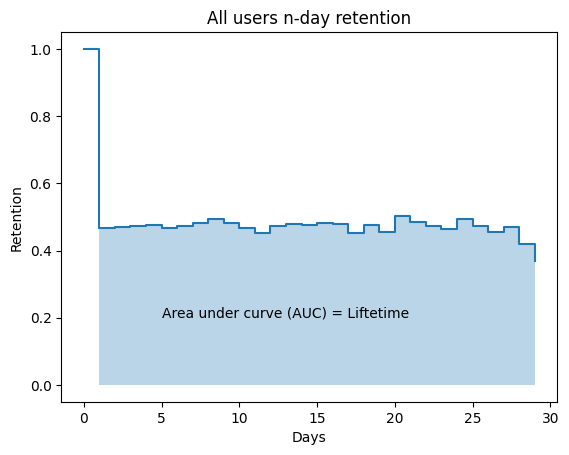

In [ ]:
# для ненудевых значений retention построим график и покажем AUC c 1 дня
graph = sns.lineplot(x=range(0, retention_max_day), y=retentions[:retention_max_day], drawstyle='steps-post')
graph.set(xlabel ="Days", ylabel = "Retention", title ='All users n-day retention')
graph.fill_between(x=range(1, retention_max_day), y1=retentions[1:retention_max_day], step='post', alpha=0.3)
plt.text(5, 0.2, 'Area under curve (AUC) = Liftetime');

Cчитаем, что каждый отрезок имеет длину по оси x равную 1. Площадь под каждым отрезком равна произведению значения y на длину отрезка по оси x.

In [ ]:
print(f'Lifetime = {sum(retentions):.2f} days')

Lifetime = 14.83 days


<a name='churn'></a>
### 4 Посчитаем Churn rate 29 дня (в долях), посчитанный по всем пользователям

In [ ]:
# объединим таблицы с данными о регистрации и активности пользователей и удалим дубликаты (случай, пользователь был активен несколо раз в течение дня)
df_registrations = pd.read_csv('registrations.csv', sep=';', parse_dates=['registration_date'], index_col='user_id')
df_entries = pd.read_csv('entries.csv', sep=';', parse_dates=['entry_date'], index_col='user_id')
data = df_registrations.join(df_entries, how='left')
data.reset_index(inplace=True)
data.drop_duplicates(inplace=True)

In [ ]:
df = data.copy()
# Вычисляем последний день активности пользователя
df = df.merge(df.groupby('user_id')['entry_date'].max().rename("last_activity_date"), on='user_id')

# Вычисляем 29-й день для каждого пользователя
df['day_29'] = df['registration_date'] + pd.Timedelta(days=29)

# Отбираем пользователей, зарегистрированных более 29 дней назад от последней даты в датасете
df_29_days = df[df['registration_date'] <= df['entry_date'].max() - pd.Timedelta(days=29)].copy()

# Проверяем, кто ушел в отток до 29-го дня
df_29_days['churned'] = df_29_days['last_activity_date'] < df_29_days['day_29']

# Рассчитываем churn rate
churn_rate = df_29_days.drop_duplicates(subset=['user_id'])['churned'].mean()

print(f"Churn rate на 29-й день: {churn_rate:.3f}")


Churn rate на 29-й день: 0.498


<a name='mau'></a><a name='wau'></a><a name='dau'></a>
### 5 Посчитаем Mau, Wau, Dau за последний месяц/неделю/день записей

**Примечание:** последний месяц записей - декабрь. Поэтому `mau` рассчитываем для декабря (2021 года), для `wau` берем последнюю неделю - с 25 по 31 декабря, и для `dau` соответственно последний день - 31 декабря.

In [ ]:
df_entries = pd.read_csv('entries.csv', sep=';', parse_dates=['entry_date'])

In [ ]:
dec_mau = df_entries[df_entries['entry_date'] > (df_entries.entry_date.max() - pd.DateOffset(months=1))].user_id.nunique()
print(f'MAU = {dec_mau}')

MAU = 133


In [ ]:
dec_wau = df_entries[df_entries['entry_date'] > (df_entries.entry_date.max() - pd.DateOffset(weeks=1))].user_id.nunique()
print(f'WAU = {dec_wau}')

DAU = 84


In [ ]:
dec_dau = df_entries[df_entries['entry_date'] > (df_entries.entry_date.max() - pd.DateOffset(days=1))].user_id.nunique()
print(f'DAU = {dec_dau}')

DAU = 47


### Посчитаем Mau, Wau, Dau усредненные

In [ ]:
avg_mau = df_entries.groupby(df_entries.entry_date.dt.month).user_id.nunique().mean()
print(f'avg MAU = {avg_mau:.3f}')

avg MAU = 102.583


In [ ]:
avg_wau = df_entries.resample('W-SUN', on='entry_date').user_id.nunique().mean()
print(f'avg WAU = {avg_wau:.3f}')

avg WAU = 89.868


In [ ]:
avg_dau = df_entries.groupby(df_entries.entry_date.dt.date).user_id.nunique().mean()
print(f'avg DAU = {avg_dau:.3f}')

avg DAU = 40.559
